# Walk on the N-N grid

In [70]:
from qiskit import *
import numpy as np
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.gate import *
import matplotlib.pyplot as plt
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit import Gate

## Useful gate

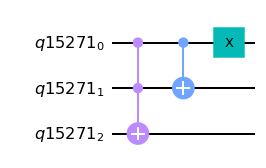

In [71]:
def increment_gate(n):
    q_r = QuantumRegister(n)
    inc = QuantumCircuit(q_r, name = 'Inc')
    for i in range(n-1,0, -1):
        inc.mct(q_r[:i], q_r[i])
    inc.x(q_r[0])
    
    return inc


increment_gate(3).draw(output ='mpl')

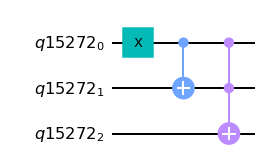

In [72]:
def decrement_gate(n):
    q_r = QuantumRegister(n)
    dec = QuantumCircuit(q_r, name = 'Dec')
    
    dec.x(q_r[0])
    for i in range(1,n):
        dec.mct(q_r[:i], q_r[i])
        
    return dec


decrement_gate(3).draw(output ='mpl')

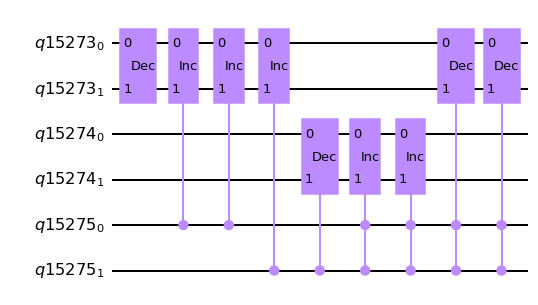

In [73]:
def shift_gate(n):
    q_r_1 = QuantumRegister(n)
    q_r_2 = QuantumRegister(n)
    q_c = QuantumRegister(2)
    shift = QuantumCircuit(q_r_1, q_r_2,q_c, name = 'Shift')
    
    dec_j = decrement_gate(n).to_gate()
    shift.append(dec_j, q_r_1[:])
    
    
    inc_j = increment_gate(n).to_gate().control(1)
    shift.append(inc_j, [q_c[0]] + q_r_1[:])
    shift.append(inc_j, [q_c[0]] + q_r_1[:])
    
    
    shift.append(inc_j, [q_c[1]] + q_r_1[:])
    
    dec_i = decrement_gate(n).to_gate().control(1)
    shift.append(dec_i, [q_c[1]] + q_r_2[:])
    
    dec = decrement_gate(n).to_gate().control(2)
    inc = increment_gate(n).to_gate().control(2)
    shift.append(inc, q_c[:] + q_r_2[:])
    shift.append(inc, q_c[:] + q_r_2[:])
    shift.append(dec, q_c[:] + q_r_1[:])
    shift.append(dec, q_c[:] + q_r_1[:])
    
    
    #shift.x( q_c[1])
        
    return shift


shift_gate(2).draw(output ='mpl')

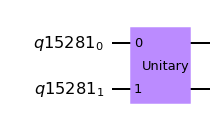

In [74]:
def grover_coin():

    q_c = QuantumRegister(2)
    coin = QuantumCircuit(q_c, name = '$G_{coin}$')

    G = Operator(np.array([
        [-1, 1, 1, 1],
        [1, -1, 1, 1],
        [1, 1, -1, 1],
        [1, 1, 1, -1]
    ])/2)

    coin.unitary(G, q_c[:])
    return coin

grover_coin().draw(output ='mpl')

## Useful functions

In [75]:
def simulate(circuit):
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(circuit, backend = simulator).result()
    counts = result.get_counts(circuit)
    return counts

In [76]:
def show(n,counts, m=2):
    grid = np.zeros((2**(n),2**(n)))
    for num in list(counts.keys()) :
        i = int(num[m+1:n+m+1], base = 2)
        j = int(num[m+n+2:m+2*n+2], base = 2)
        grid[i,j]+=counts[num]
    print(grid)
    return grid

## Walk on the NxN grid

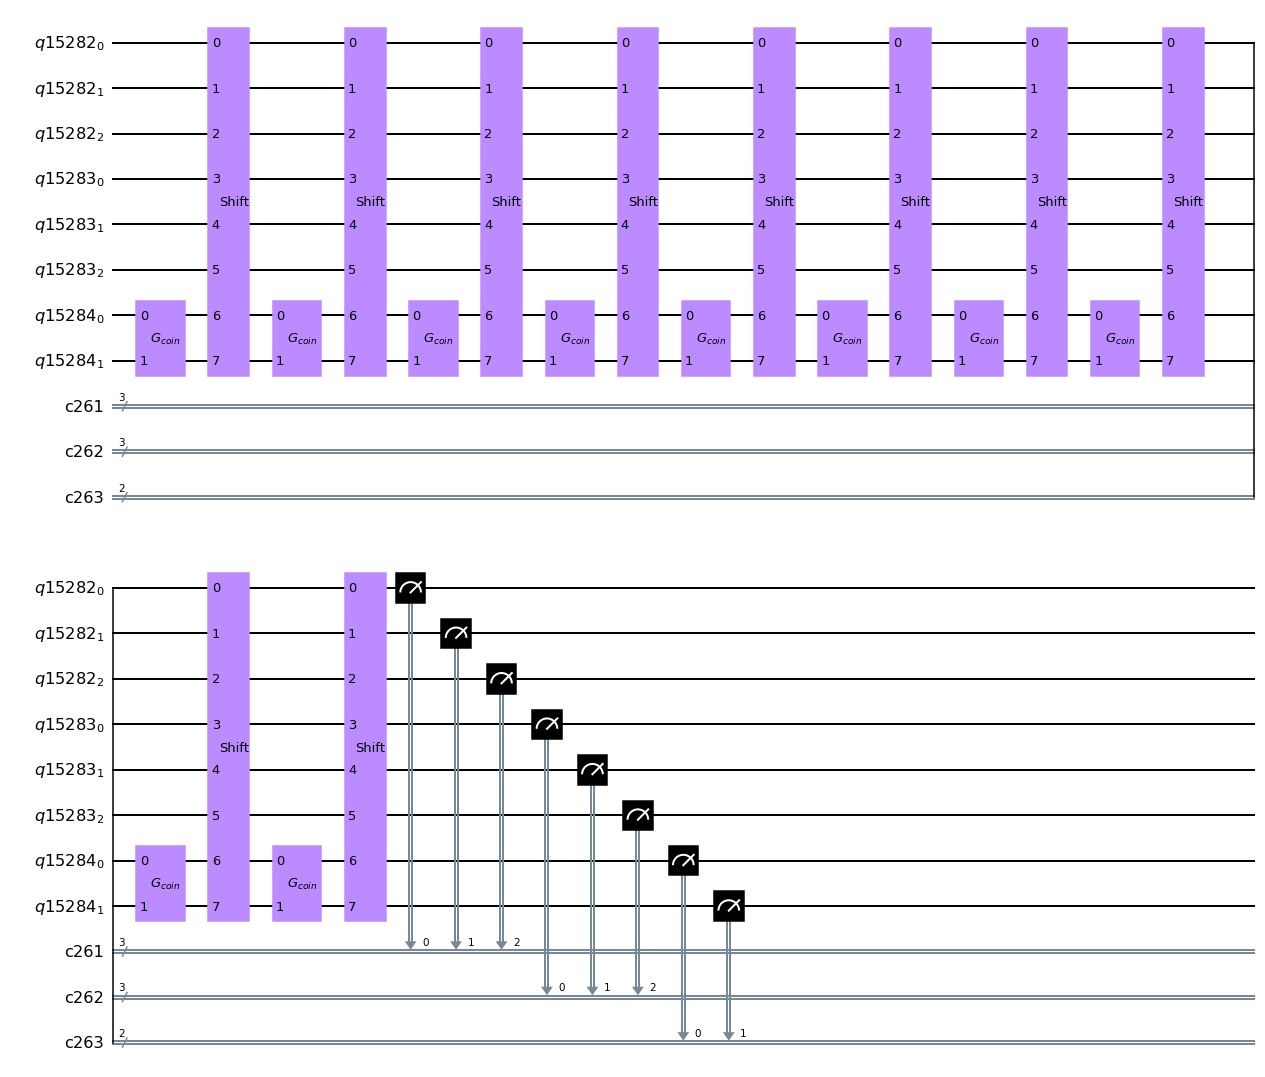

In [77]:
t = 10
n = 3
q_reg_i = QuantumRegister(n)
q_reg_j = QuantumRegister(n)
q_coin = QuantumRegister(2)
c_reg_i = ClassicalRegister(n)
c_reg_j = ClassicalRegister(n)
c_coin = ClassicalRegister(2)


circuit = QuantumCircuit(q_reg_i, q_reg_j, q_coin, c_reg_i, c_reg_j, c_coin )

#circuit.h(q_reg_i[:] + q_reg_j[:])

for _ in range(t) :
    coin = grover_coin()
    circuit.append(coin, q_coin[:])
    circuit.append(shift_gate(n), q_reg_i[:] + q_reg_j[:] + q_coin[:])


circuit.measure(q_reg_i[:] + q_reg_j[:] + q_coin[:], c_reg_i[:] + c_reg_j[:] + c_coin[:])
circuit.draw(output ='mpl')

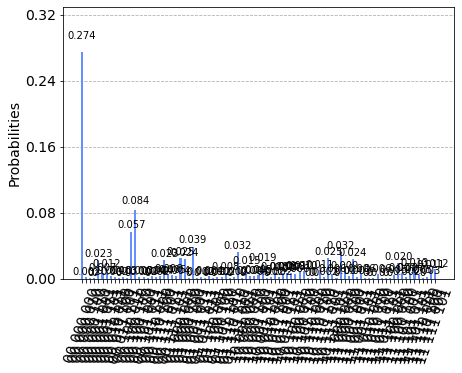

In [78]:
counts = simulate(circuit)
plot_histogram(counts)

[[355.   0.  40.   0.  10.   0.   1.   0.]
 [  0.  94.   0.  11.   0.  37.   0.   8.]
 [  5.   0.   1.   0.  15.   0.   0.   0.]
 [  0.   5.   0.  10.   0.  12.   0.  10.]
 [ 12.   0.  88.   0. 105.   0.   5.   0.]
 [  0.   4.   0.   8.   0.  21.   0.  10.]
 [  4.   0.   2.   0.  18.   0.   4.   0.]
 [  0.  94.   0.   7.   0.  23.   0.   5.]]


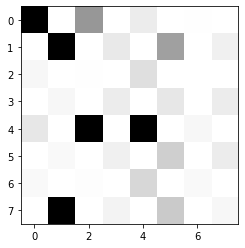

In [82]:
plt.imshow(show(n,counts)**(1.2), interpolation='nearest',vmin=0, vmax=1024/5, cmap='binary')

![SegmentLocal](grid_walk.gif "segment")